In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import surrogate, functional, BatchNormTT2d


import tonic

from IPython.display import HTML

import matplotlib.pyplot as plt

import numpy as np


from trainer import *

from deepr import DeepR

from line_profiler import LineProfiler


In [2]:
slice_meta_path = "./tmp/DVS_sliced/"

dtype=torch.float
print("Convolutional SNN Trained on DVS Gesture")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=32 #you wanna set this so that the gpu uses all its dedicated memory but not any shared i.e. not swapping to main ram
data_path='./tmp/data/DVS/'
num_classes = 11  # DVS has 10 output classes, one for out of class

frame_time = 10

num_steps = 60 #i.e. the number of frames to feed the SNN

#
transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(128,128,2),n_time_bins=num_steps),lambda x: x.astype(np.float32)]) #for some reason using time_window results in an inconsistent number of frames
#data augmentation is not an option

train_dvs = tonic.datasets.DVSGesture(data_path,train=True)
test_dvs = tonic.datasets.DVSGesture(data_path,train=False)

#this does improve performance
train_dvs_mem = tonic.MemoryCachedDataset(train_dvs)
test_dvs_mem = tonic.MemoryCachedDataset(test_dvs)

slicer = tonic.slicers.SliceByTime(60*frame_time*1000,59*frame_time*1000,False)
#59 allow an overlap such that we start a new slice at every possible frame.
#however,
 
#NOTE careful , you will need to regenerate the metadata after changing parameters, takes about 30 seconds to generate the slices
#slice our dataset into a samples of frame groups - we do not need an entire sample at once
train_sliced_dvs = tonic.SlicedDataset(train_dvs_mem,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"train/")
test_sliced_dvs = tonic.SlicedDataset(test_dvs_mem,slicer=slicer,transform=transform1,metadata_path=slice_meta_path+"test/")

#dont bother using disk cached dataset, it doesnt speed things up
#dont bother changing the overlap window either... 
#yes,dataloading is the slowest part of training

train_sampler = torch.utils.data.RandomSampler(train_sliced_dvs, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(test_sliced_dvs, generator=gtest,replacement=False)

train_loader = DataLoader(train_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(test_sliced_dvs,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=test_sampler,num_workers=1)

print("Train batches:",len(train_loader))
print("Test batches:",len(test_loader))

Convolutional SNN Trained on DVS Gesture
Using device: cuda
Metadata read from ./tmp/DVS_sliced/train/slice_metadata.h5.
Metadata read from ./tmp/DVS_sliced/test/slice_metadata.h5.
Train batches: 19723
Test batches: 5114


training samples:  631108
testing samples:  163636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hand clapping
torch.Size([60, 2, 128, 128])


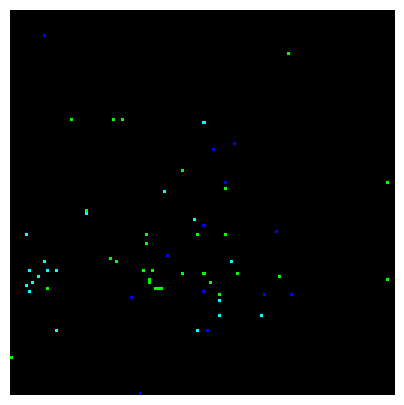

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [3]:
print("training samples: ",len(train_sliced_dvs))
print("testing samples: ",len(test_sliced_dvs))
#if you want to create more samples you can change the overlap

a = next(iter(test_loader))
print(test_dvs.classes[a[1][0]])
print(a[0][0].shape)
animation = tonic.utils.plot_animation(frames=a[0][0])
display(HTML(animation.to_jshtml()))

In [4]:


################ DVS Gesture Model #############################

# layer parameters

lr=1e-4

spike_grad1 = surrogate.atan()

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.layers = nn.ModuleList([
            nn.MaxPool2d(4),
            nn.Conv2d(2,64,3),
            BatchNormTT2d(64,num_steps),
            nn.Conv2d(64,128,3),
            BatchNormTT2d(128,num_steps),
            nn.AvgPool2d(2),
            nn.Conv2d(128,128,3),
            BatchNormTT2d(128,num_steps),
            nn.AvgPool2d(2),
            nn.Linear(4608,256),
            nn.Linear(256,11)

        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=0.3,threshold=0.3,spike_grad=spike_grad1)] * len(self.layers)
        )

        self.to(device) #yes, this is needed twice

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(len(self.layers)):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = x[:,step]


            for i in range(len(self.layers)):
                if(i==9): #need to flatten from pooling to Linear
                    spk_i = torch.flatten(spk_i,start_dim=1)

                if i in {2,4,7}:
                    spk_i = self.layers[i][step](spk_i)
                else:
                    cur_i = self.layers[i](spk_i)
                    spk_i, mem[i] = self.neurons[i](cur_i,mem[i])
                        

            spk_rec.append(spk_i)
            


        return torch.stack(spk_rec, dim=0)
    
###################################################################################



Training progress::   0%|          | 0/2000 [00:00<?, ?it/s]

Iteration: 0
Training loss: 10.53
Validation loss: 2.40
Validation accuracy: 10.42%
Training accuracy: 3.12%
----------------
Iteration: 100
Training loss: 1.31
Validation loss: 2.07
Validation accuracy: 44.79%
Training accuracy: 53.12%
----------------
Iteration: 200
Training loss: 1.94
Validation loss: 1.79
Validation accuracy: 60.94%
Training accuracy: 68.75%
----------------
Iteration: 300
Training loss: 0.70
Validation loss: 2.00
Validation accuracy: 59.90%
Training accuracy: 78.12%
----------------
Iteration: 400
Training loss: 1.45
Validation loss: 1.59
Validation accuracy: 70.83%
Training accuracy: 75.00%
----------------
Iteration: 500
Training loss: 0.68
Validation loss: 1.65
Validation accuracy: 66.67%
Training accuracy: 84.38%
----------------
Iteration: 600
Training loss: 0.56
Validation loss: 1.10
Validation accuracy: 71.88%
Training accuracy: 81.25%
----------------
Iteration: 700
Training loss: 0.34
Validation loss: 1.54
Validation accuracy: 77.60%
Training accuracy: 93

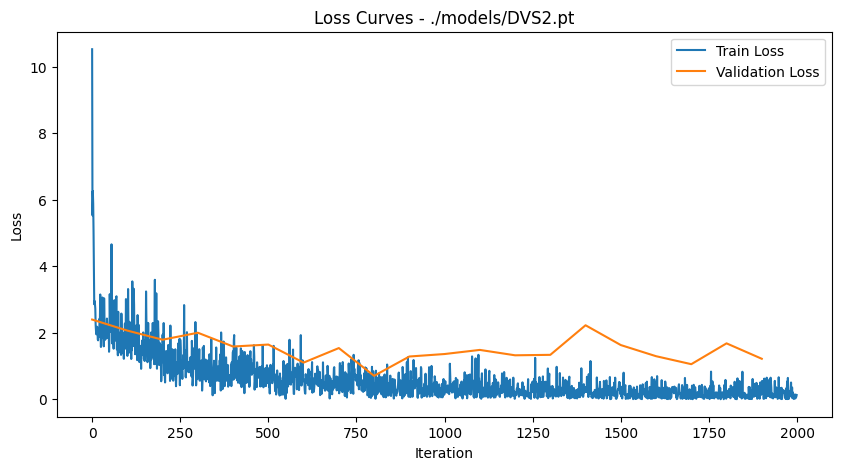

Testing progress::   0%|          | 0/500 [00:00<?, ?it/s]

Test Accuracy: 79.36%
----


: 

In [5]:
net = Net()
optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
net = trainer(net,train_loader=train_loader,valid_loader=test_loader,optimiser=optimiser,epochs=1,iterations=2000,valid_after=100,valid_iterations=6,deepr=False,device=device)
gen_reset()
a = test_stats(net,test_loader=test_loader,iterations=500,device=device)
print("----")

#model seems to be overfitting atm, however the training accuracy is pretty good
